# RNN Time Series Prediction

In [1]:
import torch
import torch.nn.functional as F
from torch import nn, optim

In [2]:
import numpy as np

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

## Data

### Fictitious Time Series

In [4]:
# Sequence length
len_sequence = 30

# Fictitious time series
time = np.linspace(0, np.pi, len_sequence + 1)
data = np.sin(time)

# Reshape data to add input size dimension
data = data.reshape(-1, 1)

assert data.shape == (len_sequence + 1, 1)

In [5]:
input = data[:-1]
target  =  data[1:]

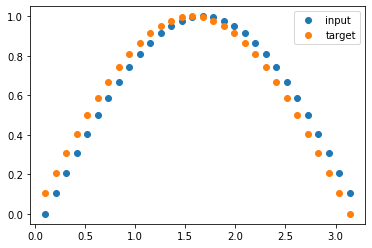

In [6]:
plt.figure()
plt.plot(time[1:], input, "o", label="input")
plt.plot(time[1:], target, "o", label="target")
plt.legend()
plt.show()

## RNN

### Definition

In [7]:
class RNN(nn.Module):
    
    def __init__(self, s_input, s_output, s_hidden, n_layers):
        super().__init__()
        
        self.s_hidden = s_hidden

        # RNN layer
        # Shape (batch, sequence, feature)
        self.rnn = nn.RNN(s_input, s_hidden, n_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(s_hidden, s_output)
        
    def forward(self, x, hidden):
        
        # Batch size, sequence length and input size
        batch_size, len_sequence, s_input = x.shape
        
        # RNN forward pass
        # Get RNN output and new RNN hidden state
        output, hidden = self.rnn(x, hidden)
        
        # Reshape output ad (batch_size * len_sequence, s_hidden)
        output = output.view(-1, self.s_hidden)  
        
        # Compute output
        output = self.fc(output)
        
        return output, hidden

### Test

In [8]:
# Define a RNN model
rnntest = RNN(s_input=1, s_output=1, s_hidden=10, n_layers=2)

# Define RNN input
# Add first batch dimension
inputtest = torch.Tensor(data[:-1]).unsqueeze(0)


output, hidden = rnntest(inputtest, None)

print(f"Input size: {inputtest.size()}")
print(f"Hidden size: {hidden.size()}")
print(f"Output size: {output.size()}")

Input size: torch.Size([1, 30, 1])
Hidden size: torch.Size([2, 1, 10])
Output size: torch.Size([30, 1])


## Training 

In [9]:
rnn = RNN(s_input=1, s_output=1, s_hidden=25, n_layers=1)

In [10]:
loss_function = nn.MSELoss()

In [11]:
optimizer = optim.Adam(rnn.parameters(), lr=0.01)

In [12]:
def train(model, epochs, print_every=25):
    
    # Initial hidden state
    hidden = None
    
    for epoch in range(epochs):
        # Training data
        time = np.linspace(epoch * np.pi, (epoch + 1) * np.pi, len_sequence + 1)
        data = np.sin(time).reshape(-1, 1)
        
        input = torch.Tensor(data[:-1]).unsqueeze(0)
        target = torch.Tensor(data[1:])
        
        output, hidden = rnn(input, hidden)
        
        # Detach the hidden state from the computational graph
        # Avoid backpropagation through the entire history
        hidden = hidden.clone().detach()
        
        # Compute the loss
        loss = loss_function(output, target)
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Backpropagation
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Print loss 
        if epoch % print_every == 0:        
            print(f"Loss: {loss.item():.5}")
            plt.figure()
            plt.plot(time[1:], input.clone().detach().numpy().squeeze(), "o", label="input")
            plt.plot(time[1:], output.clone().detach().numpy().squeeze(), "o", label="output")
            plt.legend()
            plt.show()

Loss: 0.34718


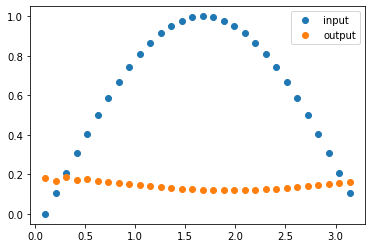

Loss: 0.009386


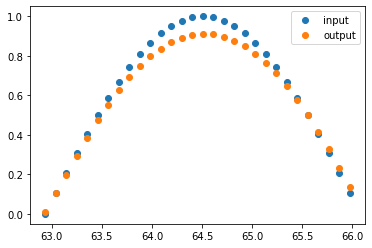

Loss: 0.0036772


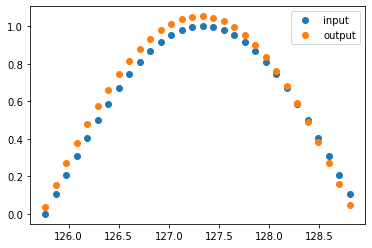

Loss: 0.00016696


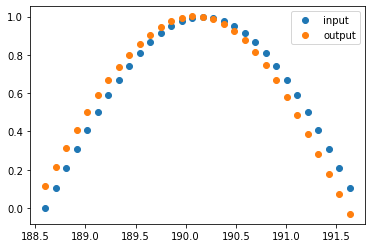

Loss: 0.00010508


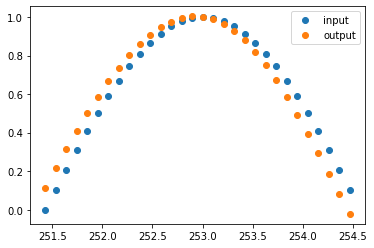

In [13]:
epochs = 100

train(rnn, epochs, 20)

## Predictions

In [14]:
time = np.linspace((epochs + 1) * np.pi, (epochs + 2) * np.pi, len_sequence)
target = np.sin(time)